Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [1]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

In [2]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Входящий', 'Выходящий']

In [3]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [4]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['06374.jpg', '00564.jpg', '04108.jpg', '00478.jpg', '06422.jpg', '03346.jpg', '01468.jpg', '05007.jpg', '03099.jpg', '03673.jpg', '04946.jpg', '03008.jpg', '01155.jpg', '04521.jpg', '01855.jpg', '03413.jpg', '04271.jpg', '01679.jpg', '02763.jpg', '00926.jpg', '04895.jpg', '05604.jpg', '03608.jpg', '05087.jpg', '04544.jpg', '04596.jpg', '00227.jpg', '06016.jpg', '03847.jpg', '03116.jpg', '00945.jpg', '00055.jpg', '01878.jpg', '03470.jpg', '04162.jpg', '00673.jpg', '00294.jpg', '05704.jpg', '01427.jpg', '02282.jpg', '03037.jpg', '01684.jpg', '01113.jpg', '02330.jpg', '01544.jpg', '00783.jpg', '03756.jpg', '06162.jpg', '05628.jpg', '00866.jpg', '03869.jpg', '03669.jpg', '03628.jpg', '03409.jpg', '02232.jpg', '04585.jpg', '04344.jpg', '05678.jpg', '05083.jpg', '05312.jpg', '01043.jpg', '04938.jpg', '00730.jpg', '03384.jpg', '04699.jpg', '05469.jpg', '01196.jpg', '05121.jpg', '05911.jpg', '04615.jpg', '06352.jpg', '02671.jpg', '00547.jpg', '00646.jpg', '06036.jpg', '05289.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

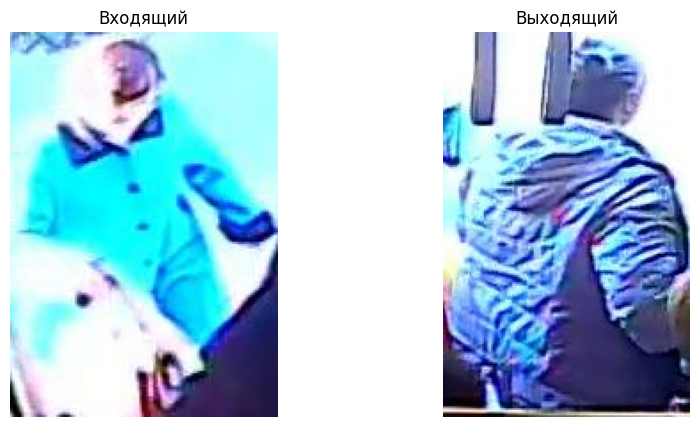

In [5]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [6]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


Загрузка и распаковка архива bus.zip...
replace /content/bus/Входящий/01009.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/bus/Входящий/03889.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace /content/bus/Входящий/05711.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: к
error:  invalid response [к]
replace /content/bus/Входящий/05711.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: к
error:  invalid response [к]
replace /content/bus/Входящий/05711.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: 05777
replace /content/bus/Входящий/06465.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/bus/Входящий/05859.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/bus/Входящий/05859.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/bus/Входящий/05859.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Распаковка завершена!
Found 7265 images belonging to 2 classes.
Found 1816 images belonging to 2 cl

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
228/228 ━━━━━━━━━━━━━━━━━━━━ 63s 240ms/step - accuracy: 0.7383 - loss: 2.7469 - val_accuracy: 0.4747 - val_loss: 4.5081
Epoch 2/12
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - accuracy: 0.8550 - loss: 0.3345 - val_accuracy: 0.5006 - val_loss: 1.5448
Epoch 3/12
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - accuracy: 0.8783 - loss: 0.2762 - val_accuracy: 0.7412 - val_loss: 1.6683
Epoch 4/12
228/228 ━━━━━━━━━━━━━━━━━━━━ 82s 222ms/step - accuracy: 0.8973 - loss: 0.2312 - val_accuracy: 0.7489 - val_loss: 0.9782
Epoch 5/12
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - accuracy: 0.9058 - loss: 0.2204 - val_accuracy: 0.7467 - val_loss: 1.5189
Epoch 6/12
228/228 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - accuracy: 0.9097 - loss: 0.1993 - val_accuracy: 0.7456 - val_loss: 2.3791
Epoch 7/12
228/228 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - accuracy: 0.9252 - loss: 0.1867 - val_accuracy: 0.6762 - val_loss: 0.7097
Epoch 8/12
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - accuracy: 0.9247 - loss: 0

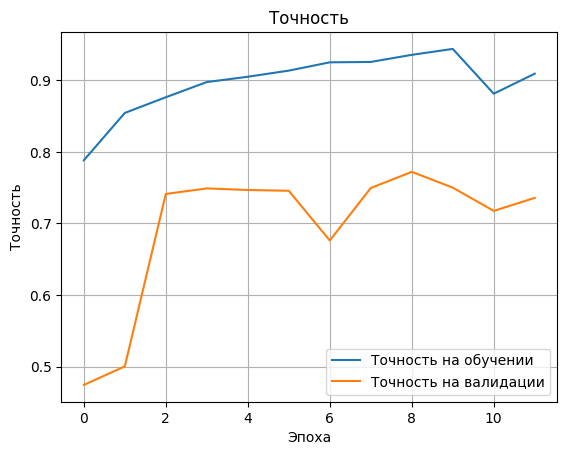

⚠️ Модель не достигла 90% точности. Попробуйте изменить архитектуру или параметры обучения.


In [8]:
# Импорт необходимых библиотек
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import gdown

# Скачивание и распаковка архива с данными
print("Загрузка и распаковка архива bus.zip...")
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)
!unzip -q "bus.zip" -d /content/bus
print("Распаковка завершена!")

# Пути к директориям
IMAGE_PATH = '/content/bus'
train_dir = os.path.join(IMAGE_PATH, "Входящий")
val_dir = os.path.join(IMAGE_PATH, "Выходящий")

# Проверка наличия директорий
if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    raise FileNotFoundError("Папки 'Входящий' или 'Выходящий' не найдены. Проверьте структуру архива.")

# Создание генераторов изображений
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, rotation_range=15, horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    IMAGE_PATH, target_size=(150, 150), batch_size=32, class_mode='binary', subset='training'
)
val_generator = train_datagen.flow_from_directory(
    IMAGE_PATH, target_size=(150, 150), batch_size=32, class_mode='binary', subset='validation'
)

# Создание модели
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(train_generator, epochs=12, validation_data=val_generator, verbose=1)

# Оценка точности
val_loss, val_acc = model.evaluate(val_generator)
print(f"Точность на проверочной выборке: {val_acc:.4f}")

# График
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('Точность')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)
plt.show()
